In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,StratifiedKFold, cross_val_score, train_test_split
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#read data scikit-learn
os.chdir('C:/Users/Katharina/Desktop/Weiterbildung/Bootcamp/Bootcamp/Final_project/data')
#data = pd.read_csv('DatenML_V2_relCol.csv', sep=';')
data = pd.read_csv('DatenML_V2_relCol_ZusatzType.csv', sep=';')

In [4]:
data['Type'].unique()

array([ 4, 33,  5, 42, 51, 52])

In [3]:
df = data
# Erstellen der neuen Spalte "Team1":
# Wenn TeamDesignation = A, dann soll TeamAName in Team1 stehen,
# andernfalls (also bei B) TeamBName.
df["Team1"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamAName"],
    df["@TeamBName"]
)

# Erstellen der Spalte "Team2" als das jeweils andere Team:
df["Team2"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamBName"],
    df["@TeamAName"]
)



In [57]:
#Für streamlit abspeichern
df.to_csv('ML_MatchWin_Weather2.csv', index=False, sep=';')

In [9]:
#bestimmte Variablen entfernen
data1 = df.drop([ 'TeamDesignation','@PointsTeamASet1', '@PointsTeamBSet1', '@PointsTeamASet2',
       '@PointsTeamBSet2', '@PointsTeamASet3', '@PointsTeamBSet3', 
       'FederationCode_y', '@TeamAName', '@TeamBName',
       '@LocalDate', '@LocalTime',
       #neu
       'Type','TournamentNo','NoPlayer1_team', 'NoPlayer2_team'#'total_A', 'total_B', 'TeamName'-> nicht mehr da
], axis=1)
#'Gender_x',

In [10]:
y = data1.pop('match_win')
X = data1.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

In [11]:
special_feature = '@DurationSet3'

# Kopiere die Trainingsdaten, um das Original nicht zu überschreiben
X_train = X_train.copy()

# Erzeuge den Indikator: 1, wenn in @DurationSet3 ein Wert vorhanden ist, sonst 0.
X_train[special_feature + '_indicator'] = X_train[special_feature].notnull().astype(int)

# Für die Testdaten ebenfalls:
X_test = X_test.copy()
X_test[special_feature + '_indicator'] = X_test[special_feature].notnull().astype(int)


In [12]:
nominal_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Erstelle eine Liste der allgemeinen numerischen Features, exklusive des speziellen Features und dessen Indikator
general_numeric_features = [col for col in numeric_features if col not in [special_feature, special_feature + '_indicator']]

# Erstelle separate Pipelines:
# 1. Für allgemeine numerische Features mit KNNImputer
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# 2. Für das spezielle Feature, das immer mit 0 imputiert werden soll (das signalisiert, dass kein dritter Satz stattgefunden hat)
special_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# 3. Für die Indikatorspalte (@DurationSet3_indicator)
indicator_transformer = Pipeline(steps=[
    # Hier ist meist keine Imputation nötig; Skalierung ist optional, da 0 und 1 oft schon aussagekräftig sind.
    ('scaler', StandardScaler())
])

# 4. Für nominale Features: Imputation mit dem häufigsten Wert + OneHotEncoding
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Baue den ColumnTransformer unter Berücksichtigung aller Feature-Gruppen:
transformers = [
    ('num', numeric_transformer, general_numeric_features),
    ('spec_num', special_numeric_transformer, [special_feature]),
    ('indicator', indicator_transformer, [special_feature + '_indicator']),
    ('nom', nominal_transformer, nominal_features)
]

preprocessor = ColumnTransformer(transformers=transformers)

In [ ]:
# # select categorical and numerical column names
# nominal_features = X.select_dtypes(include=['object']).columns.tolist()
# # Define feature types
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# # Create preprocessors for different feature types
# numeric_transformer = Pipeline(steps=[
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', StandardScaler())
# ])

# nominal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])

# # Build the column transformer
# transformers = [
#     ('num', numeric_transformer, numeric_features),
#     ('nom', nominal_transformer, nominal_features)
# ]

# preprocessor = ColumnTransformer(transformers=transformers)

In [7]:
#Model Building
# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, 
                                         min_samples_split=5, min_samples_leaf=2),
     'GradientBoosting': GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                  max_depth=5, subsample=0.8)
}

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [29]:
# Function to train and evaluate models
def evaluate_model(name, model, X, y, cv):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    
    print(f"{name} - Cross-validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train on full dataset for feature importance
    pipeline.fit(X, y)
    
    return pipeline


Training RandomForest...
RandomForest - Cross-validation Accuracy: 0.8323 (±0.0102)

Training GradientBoosting...
GradientBoosting - Cross-validation Accuracy: 0.8614 (±0.0038)

Top 20 most important features:
                         Feature  Importance
4                     ServeTotal    0.461648
0                     SpikeFault    0.166063
9                     SpikeTotal    0.096338
8                 ReceptionFault    0.038598
15                TeamFault_team    0.025499
1                     SpikePoint    0.024646
5                     BlockPoint    0.020119
2                     ServeFault    0.017407
3                     ServePoint    0.012582
6                     BlockTotal    0.011097
7                       DigTotal    0.007404
12                wind_speed_10m    0.006602
10                temperature_2m    0.005113
14                wind_gusts_10m    0.004775
1139     Team2_Perusic/Schweiner    0.001539
775       Team2_Brouwer/Meeuwsen    0.001394
348        Team1_Krattig

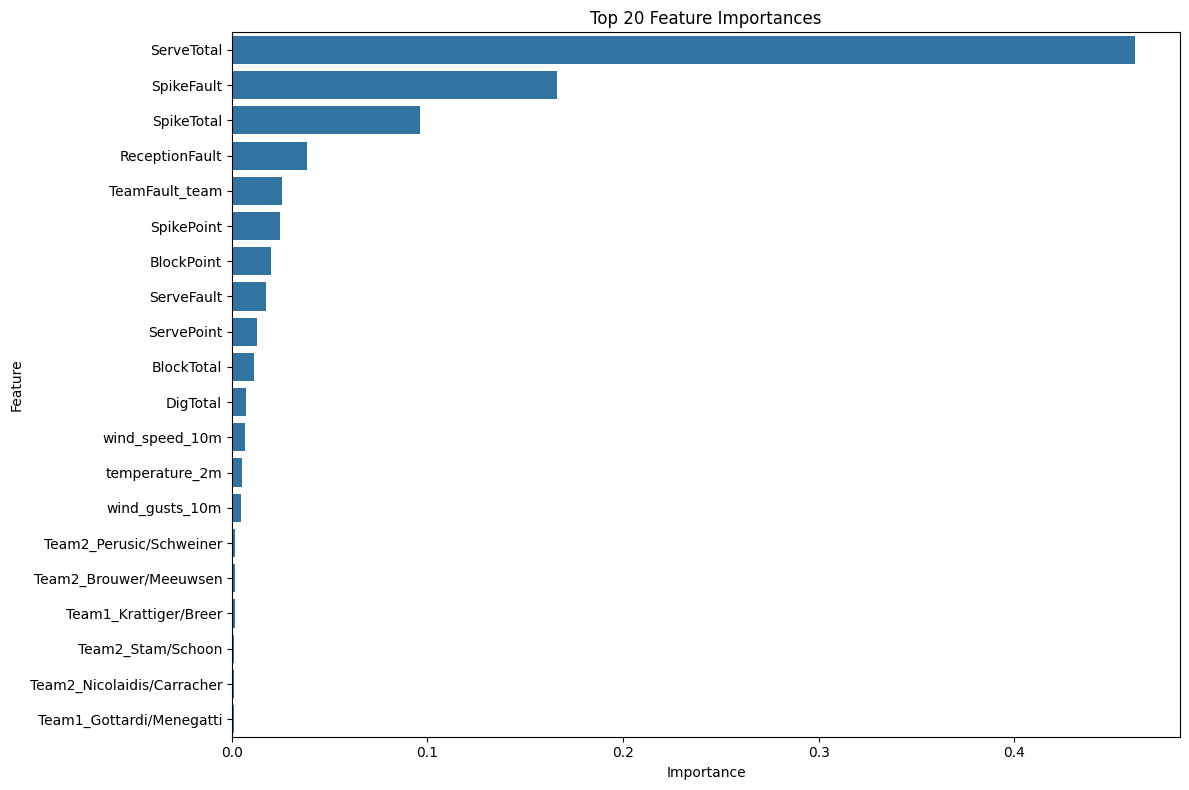

In [30]:
# Evaluate all models
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = evaluate_model(name, model, X, y, cv)
    trained_models[name] = pipeline

# Get feature importance from one of the tree-based models (e.g., Random Forest)
rf_model = trained_models['GradientBoosting']
preprocessed_X = rf_model.named_steps['preprocessor'].transform(X)

# Get feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'nom':
        ohe = trans.named_steps['onehot']
        feature_names.extend([f"{col}_{cat}" for col in cols 
                            for cat in ohe.categories_[cols.index(col)]])
    else:  # ordinal features
        feature_names.append(name[4:])  # Remove 'ord_' prefix

# Get and display feature importances
if hasattr(rf_model.named_steps['classifier'], 'feature_importances_'):
    importances = rf_model.named_steps['classifier'].feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure lengths match
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    print(importance_df.head(20))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()

## Model abspeichern 

In [13]:
#RandomForestClassifier
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, 
                                         min_samples_split=5, min_samples_leaf=2))
    ])

rf = pipeline.fit(X_train, y_train)


# Vorhersagen
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
# Vorhersagen auf den Trainingsdaten
y_train_pred = rf.predict(X_train)

# Accuracy auf Trainingsdaten
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Trainings-Accuracy: {train_acc:.2f}")

Model Accuracy: 0.8056
Trainings-Accuracy: 0.85


In [ ]:
# Trainieren der Pipeline
#pipeline.fit(X_train, y_train)



Model Accuracy: 0.8153
Trainings-Accuracy: 0.85


In [14]:
import joblib
# Modell speichern als .pkl-Datei
joblib.dump(rf, "random_forest_model_V2_NEU.pkl")

['random_forest_model_V2_NEU.pkl']

In [15]:
#Gradient Boosting
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                  max_depth=5, subsample=0.8))
])

GB = pipeline2.fit(X_train, y_train)
# Vorhersagen
y_pred2 = pipeline2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)

print(f"Model Accuracy: {accuracy2:.4f}")

# Vorhersagen auf den Trainingsdaten
y_train_pred2 = GB.predict(X_train)

# Accuracy auf Trainingsdaten
train_acc2 = accuracy_score(y_train, y_train_pred2)
print(f"Trainings-Accuracy: {train_acc2:.2f}")


Model Accuracy: 0.8712
Trainings-Accuracy: 0.96


In [ ]:
# Trainieren der Pipeline
#pipeline2.fit(X_train, y_train)



Model Accuracy: 0.8670
Trainings-Accuracy: 0.94


In [ ]:
#abspeichern
joblib.dump(GB, "GradientBoosting_model_V2_NEU.pkl")


['GradientBoosting_model_V2.pkl']

## neuer part

neu

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Definiere verschiedene ML-Modelle
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression()
}

# GridSearch-Hyperparameter für verschiedene Modelle
param_grids = {
    "Random Forest": {
        "randomforestclassifier__n_estimators": [50, 100, 200],
        "randomforestclassifier__max_depth": range(2, 8, 2)
    },
    "Gradient Boosting": {
        "gradientboostingclassifier__n_estimators": [50, 100, 200],
        "gradientboostingclassifier__learning_rate": [0.01, 0.1, 0.2]
    },
    "SVM": {
        "svc__C": [0.1, 1, 10],
        "svc__kernel": ["linear", "rbf"]
    },
    "Logistic Regression": {
        "logisticregression__C": [0.1, 1, 10]  
    }
}

# Dictionary zum Speichern der Ergebnisse
results = {}

# GridSearchCV für jedes Modell durchführen
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)  # Pipeline mit Preprocessing + ML-Modell
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, verbose=1)  # Cross-Validation
    grid.fit(X_train, y_train)  # Training
    
    # Speichert den besten Score und die besten Parameter
    results[name] = {
        "best_score": grid.best_score_,
        "best_params": grid.best_params_
    }

# Ausgabe der besten Scores und Parameter für jedes Modell
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(f"Best Score: {result['best_score']:.4f}")
    print(f"Best Parameters: {result['best_params']}")


In [17]:
   # Ausgabe der gesamten CV-Ergebnisse für das aktuelle Modell
# Umwandlung in normale Floats
scores_normal = {key: float(value) for key, value in scores.items()}

print(scores_normal)

{'Random Forest': 0.8148192056905751, 'Gradient Boosting': 0.8603438055720213, 'SVM': 0.8524007113218731, 'Logistic Regression': 0.8417308832246592}


In [20]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Feature Selection hinzufügen (z.B. SelectKBest mit mutual_info_classif)
feature_selector = SelectKBest(score_func=mutual_info_classif, k=10)

# Komplette Pipeline mit Preprocessing, Feature Selection und ML-Modell
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Trainieren der Pipeline
pipeline.fit(X_train, y_train)

# Vorhersagen
y_pred = pipeline.predict(X_test)


## Code wie im Notebook WBS

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# Define a function to perform a grid search, which helps to avoid duplicating code for different models
def run_grid_search(model, param_grid, cv=5, verbose=1):
    # Create a pipeline that first applies the data preprocessing steps, then fits the model
    pipe = make_pipeline(preprocessor, MinMaxScaler(), model)

    # GridSearchCV will test all possible combinations of parameters defined in 'param_grid'
    grid_search = GridSearchCV(pipe, param_grid, cv=cv, verbose=verbose, n_jobs=-2)

    # Fit the model on the training data with the various parameter combinations
    grid_search.fit(X_train, y_train)

    # Return the trained GridSearchCV object which holds the best parameters and model
    return grid_search



In [13]:
# Define a dictionary of hyperparameters to tune for the decision tree model
dt_param_grid = {
    "decisiontreeclassifier__max_depth": range(3, 8),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

# Run the grid search for the DecisionTreeClassifier using the specified parameters
dt_search = run_grid_search(
    DecisionTreeClassifier(random_state=123),
    dt_param_grid,
)

# Display the process
dt_search

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SpikeFault',
                                                                          'SpikePoint',
                                                                          'ServeFault',
                                                                          'ServePoint',
                                                                          'ServeTotal',
                                                                          'BlockPoint',
                                                                          'BlockTotal',
                                                                          'DigTotal',
                                                                          'ReceptionFault',
                                                                          'SpikeTotal',
                                                                          'temperature_2m',
                                                                          'precipitation',
                                                                          'wind_spe...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Team1',
                                                                          'Team2'])])),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=-2,
             param_grid={'decisiontreeclassifier__max_depth': range(3, 8),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 12, 2)},
             verbose=1)

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score,
    cohen_kappa_score,
    make_scorer
)

scoring = {
        "Accuracy": accuracy_score,
        "Recall": recall_score,
        "Precision": precision_score,
        "F1 Score": f1_score,
        "Balanced Accuracy": balanced_accuracy_score,
        "Cohen's Kappa": cohen_kappa_score
    }
scoring = {metric: make_scorer(scoring[metric]) for metric in scoring}

# Function to get the scores for our model(s)
def evaluate_model(model, model_name):
    scores = cross_validate(model, X_train, y_train, cv=10, scoring=scoring)
    scores["Model"] = model_name
    return scores

# Create an empty DataFrame to store model evaluation results
model_scores_df = pd.DataFrame(columns=[
    "Accuracy", "Recall", "Precision",
    "F1 Score", "Balanced Accuracy", "Cohen's Kappa"
])

# Evaluate the Decision Tree model
dt_scores = evaluate_model(dt_search, "Decision Tree")

# # Convert the dictionary to a Series matching the DataFrame columns, then assign as a new row
def track_model_scores(model_scores_df, scores):
    model_scores_df.loc[scores["Model"]] = pd.Series(scores).iloc[2:-1].rename(lambda x: x[5:]).apply(lambda x: sum(x)/len(x))
    return model_scores_df


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [15]:
model_scores_df = track_model_scores(model_scores_df, dt_scores)

# # Display the DataFrame
model_scores_df

,Accuracy,Recall,Precision,F1 Score,Balanced Accuracy,Cohen's Kappa
Decision Tree,0.822524,0.844363,0.800519,0.821407,0.823217,0.645296


In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameter grid to be searched by the grid search
knn_param_grid = {
    #"kneighborsclassifier__n_neighbors": range(1, 11),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}

# Run a grid search to find the optimal combination of hyperparameters
knn_search = run_grid_search(
    KNeighborsClassifier(),
    knn_param_grid,
)

# Display the grid search results
knn_search

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SpikeFault',
                                                                          'SpikePoint',
                                                                          'ServeFault',
                                                                          'ServePoint',
                                                                          'ServeTotal',
                                                                          'BlockPoint',
                                                                          'BlockTotal',
                                                                          'DigTotal',
                                                                          'ReceptionFault',
                                                                          'SpikeTotal',
                                                                          'temperature_2m',
                                                                          'precipitation',
                                                                          'wind_spe...
                                                                          'TeamFault_team']),
                                                                        ('nom',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Team1',
                                                                          'Team2'])])),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-2,
             param_grid={'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             verbose=1)

In [17]:
# Evaluate the K-Nearest Neighbours (KNN) model using the testing dataset and obtain performance metrics
knn_scores = evaluate_model(knn_search, "KNN")

# Append the KNN metrics as a new row to the existing DataFrame of model scores
model_scores_df = track_model_scores(model_scores_df, knn_scores)

# Display the updated DataFrame containing all model performance metrics
model_scores_df

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


,Accuracy,Recall,Precision,F1 Score,Balanced Accuracy,Cohen's Kappa
Decision Tree,0.822524,0.844363,0.800519,0.821407,0.823217,0.645296
KNN,0.698635,0.699510,0.684658,0.691905,0.698662,0.397056


In [20]:

# Define the hyperparameter grid to be searched by the grid search
rf_param_grid = {
    "randomforestclassifier__n_estimators": [50, 100],  # Anzahl der Bäume im Wald
    "randomforestclassifier__max_depth": range(2, 8, 2),  # Maximale Tiefe der Bäume
    "randomforestclassifier__min_samples_split": [2, 5, 10],  # Minimale Anzahl von Samples, um einen Split durchzuführen
    "randomforestclassifier__min_samples_leaf": [1, 3, 5]
}

# Run a grid search to find the optimal combination of hyperparameters
rf_search = run_grid_search(
    RandomForestClassifier(),
    rf_param_grid,
)

# Display the grid search results
rf_search

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SpikeFault',
                                                                          'SpikePoint',
                                                                          'ServeFault',
                                                                          'ServePoint',
                                                                          'ServeTotal',
                                                                          'BlockPoint',
                                                                          'BlockTotal',
                                                                          'DigTotal',
                                                                          'ReceptionFault',
                                                                          'SpikeTotal',
                                                                          'temperature_2m',
                                                                          'precipitation',
                                                                          'wind_spe...
                                                                                                        sparse_output=False))]),
                                                                         ['Team1',
                                                                          'Team2'])])),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'randomforestclassifier__max_depth': range(2, 8, 2),
                         'randomforestclassifier__min_samples_leaf': [1, 3, 5],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [50, 100]},
             verbose=1)

In [ ]:
# Evaluierung auf dem besten Modell aus GridSearchCV
rf_best_model = rf_search.best_estimator_  # Extrahiert das Modell mit den besten Parametern
rf_scores = evaluate_model(rf_best_model, "RandomForest")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SpikeFault', 'SpikePoint',
                                                   'ServeFault', 'ServePoint',
                                                   'ServeTotal', 'BlockPoint',
                                                   'BlockTotal', 'DigTotal',
                                                   'ReceptionFault',
                                                   'SpikeTotal',
                                                   'temperature_2m',
                                                   'precipitation',
                                                   'wind_speed_10m', 'rain',
                                                   'wind_gusts_10m',
                                                   'TeamFault_team']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Team1', 'Team2'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=3))])

In [21]:
# Evaluate the K-Nearest Neighbours (KNN) model using the testing dataset and obtain performance metrics
rf_scores = evaluate_model(rf_search, "RandomForest")

# Append the KNN metrics as a new row to the existing DataFrame of model scores
model_scores_df = track_model_scores(model_scores_df, rf_scores)

# Display the updated DataFrame containing all model performance metrics
model_scores_df

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


,Accuracy,Recall,Precision,F1 Score,Balanced Accuracy,Cohen's Kappa
Decision Tree,0.822524,0.844363,0.800519,0.821407,0.823217,0.645296
KNN,0.698635,0.699510,0.684658,0.691905,0.698662,0.397056
RandomForest,0.812806,0.819853,0.800503,0.808669,0.813027,0.625522


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_param_grid = {
    "gradientboostingclassifier__n_estimators": [50, 100],  # Anzahl der Boosting-Iterationen
    #"gradientboostingclassifier__learning_rate": [0.01, 0.1, 0.2],  # Geschwindigkeit der Anpassung
    "gradientboostingclassifier__max_depth": range(3, 10, 2),  # Maximale Tiefe der Bäume
    "gradientboostingclassifier__min_samples_split": [2, 5, 10],  # Mindestanzahl an Samples für einen Split
    "gradientboostingclassifier__min_samples_leaf": [1, 3, 5]  # Mindestanzahl von Samples pro Blattknoten
}

# Grid Search für Gradient Boosting
gb_search = run_grid_search(
    GradientBoostingClassifier(random_state=123),
    gb_param_grid,
)

In [ ]:
# Evaluate the K-Nearest Neighbours (KNN) model using the testing dataset and obtain performance metrics
gb_scores = evaluate_model(rf_search, "Gradient Boosting")

# Append the KNN metrics as a new row to the existing DataFrame of model scores
model_scores_df = track_model_scores(model_scores_df, gb_scores)

# Display the updated DataFrame containing all model performance metrics
model_scores_df